# ghg_analytics
## Insights into trends with global greenhouse gases and climate change action.

EPA1333 – Computer Engineering for Scientific Computing Final Project

### Authors
Group 6:
* Aashna Mittal
* Gamze Ünlü
* Jason R Wang

## Introduction

Anthropogenic climate change was first introduced into the global political arena as the United Nations Framework on Climate Change Convention (UNFCCC) in 1992. Since then, other international agreements have continued to refine mitigation action.

At 19th Conference of the Parties (to the UNFCCC) in 2013 in Warsaw, the UNFCCC members agreed to submit "Intended Nationally Determined Contributions" (INDCs) to signal what each country's greenhouse gas emission targets would be. At the 21st Conference in 2015, the Paris Agreement formalized these _intended_ emissions into simply "Nationally Determined Contributions" (NDCs).

Furthermore, the signatories to the Paris Agreement (which includes all UNFCCC signatories, and therefore, all UN member nations) have agreed to maintain global warming to 2ºC, but preferrably 1.5ºC, above pre-industrial levels. This Notebook intends to analyze the NDCs to estimate their potential to reach these temperature goals.

In [1]:
# Library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import NaN
plt.style.use('ggplot')

## 1. NDCs and Temperature Targets

To determine the impact of NDCs, we need to first understand their context by answering the following questions:
1. What do global emissions look like today?
2. If nothing changes, and the world continues doing _business as usual_ (BAU), how will the world look like in 2030?

Then, we can examine how NDCs compare:
3. If all NDCs are met, what will the total amount of emissions be?
4. What emission amounts are required to meet temperature targets?

Finally, all of this will be compared in 1.5.

_Note: Emissions are quantified in units of 'megatons of carbon dioxide-equivalent per year' [MtCO2e/yr] because the strength all greenhouse gases are measured relative to carbon dioxide and because the carbon cycle is a process. Global climate targets assume that natural GHG uptake will continue steadily, so reducing the rate of emissions from countries will lead to a net decrease in the concentration of GHGs in the atmosphere._

### 1.1 Current Greenhouse Gas Emissions

The World Bank and the World Resources Institute both maintain databases of current GHG emissions. The primary data source is from the UNFCCC's reporting window; each UNFCCC member submits annual 'GHG Inventories', which track national emissions with two-year delay.

First examine WB data, which holds GHGs in ktCO2e.
    
Source: https://data.worldbank.org/indicator/EN.ATM.GHGT.KT.CE?view=chart
(Is this true, Aashna? Yes!) - Jason

In [2]:
# Import World Bank data on GHGs
ghgDf_WBoriginal = pd.read_csv("data/GreenhouseGasData.csv", sep=',', skipinitialspace=True, skiprows=4) 

# Drop the indicator name and indicator code as the values are same across the whole dataframe
ghgDf_WB = ghgDf_WBoriginal.drop(["Indicator Code", "Indicator Name"], axis = 1)

# Drop all the columns that contain only null values
ghgDf_WB.dropna(axis = 1, how="all", inplace=True)  

# Drop all the rows that contain only null values, starting from column 2
ghgDf_WB.dropna(axis = 0, how="all", subset = ghgDf_WB.columns[2:], inplace= True)  

# Interpolate missing values and then use backfill to fill starting NA values of a row
ghgDf_WB.iloc[:,2:] = ghgDf_WB.iloc[:,2:].interpolate(axis = 1).bfill(axis=1)

# Convert all emissions data into MtCO2e
ghgDf_WB.iloc[:,2:] = ghgDf_WB.iloc[:,2:].divide(1000)

In [3]:
# View the cleaned WB GHG DataFrame
ghgDf_WB.head()

,Country Name,Country Code,1970,1971,1972,1973,1974,1975,1976,1977,...,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
0,Aruba,ABW,0.042306,0.042787,0.043287,0.043725,0.044131,0.044482,0.131634,0.135055,...,0.616929,0.616929,0.616929,0.616929,0.616929,0.616929,0.616929,0.616929,0.616929,0.616929
1,Afghanistan,AFG,14.306616,14.391778,13.040848,13.535754,14.945968,14.574164,14.746851,15.247281,...,14.709884,14.654374,14.770264,14.849159,15.272633,15.288776,15.554429,17.791330,17.981307,18.168860
2,Angola,AGO,60.648601,39.162171,42.205651,44.252669,40.179234,44.429300,38.448024,43.563412,...,35.858015,36.860233,35.855738,36.375822,36.690534,37.396294,38.309465,40.029392,40.878652,41.657165
3,Albania,ALB,6.960868,6.950036,7.613266,7.348492,7.632664,7.873037,8.470978,8.948981,...,7.834016,7.401102,8.308386,8.027150,9.879394,8.136785,8.108812,8.506996,8.712296,8.898641
5,Arab World,ARB,552.362062,576.946152,625.015944,699.280217,679.448006,683.966235,775.863730,799.971041,...,1963.193015,1660.586949,1767.878645,1731.288792,2355.481347,2364.088663,2387.502011,1924.244973,2483.349104,1908.696042


In [4]:
ghgDf_WB[ ghgDf_WB['Country Name'] == 'World' ]['2012']

257    53526.302828
Name: 2012, dtype: float64

### Create Comparison for Country Group Codes and Names
The greenhouse gas database provided by the World Bank contains a lot of country aggregates such as middle-income countries, low-income countries, etc. For further analysis, we import another dataset that provides a list of these aggregate country codes to provide an index for subsetting and creating a separate dataframe that only contains country data.  

In [5]:
#Import the dataframe which contains the codes of country group aggregates
CountryGroupCodes = pd.read_excel("data/CountryGroups.xls", sheet_name = "List of economies", skiprows=226, header = None)
CountryGroupCodes.dropna(how="all", inplace=True, axis=1)
CountryGroupCodes.drop(columns=0,inplace=True)
CountryGroupCodes.dropna(how="all", inplace=True, axis=0)
CountryGroupCodes.columns = ["Aggregate Name", "Aggregate Code"]
CountryGroupCodes

# Drop the rows corresponding to aggregate country codes from existing dataframe to create a new country dataframe 
ghgCountryDf_WB = ghgDf_WB[ghgDf_WB["Country Code"].apply(lambda x: False if x in CountryGroupCodes["Aggregate Code"].values else True)]

ghgCountryDf_WB.head()

,Country Name,Country Code,1970,1971,1972,1973,1974,1975,1976,1977,...,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
0,Aruba,ABW,0.042306,0.042787,0.043287,0.043725,0.044131,0.044482,0.131634,0.135055,...,0.616929,0.616929,0.616929,0.616929,0.616929,0.616929,0.616929,0.616929,0.616929,0.616929
1,Afghanistan,AFG,14.306616,14.391778,13.040848,13.535754,14.945968,14.574164,14.746851,15.247281,...,14.709884,14.654374,14.770264,14.849159,15.272633,15.288776,15.554429,17.791330,17.981307,18.168860
2,Angola,AGO,60.648601,39.162171,42.205651,44.252669,40.179234,44.429300,38.448024,43.563412,...,35.858015,36.860233,35.855738,36.375822,36.690534,37.396294,38.309465,40.029392,40.878652,41.657165
3,Albania,ALB,6.960868,6.950036,7.613266,7.348492,7.632664,7.873037,8.470978,8.948981,...,7.834016,7.401102,8.308386,8.027150,9.879394,8.136785,8.108812,8.506996,8.712296,8.898641
6,United Arab Emirates,ARE,32.962189,41.377845,44.905463,56.875508,57.411527,57.798603,70.352619,69.646400,...,134.091686,139.999464,143.367663,151.837320,167.986432,181.388536,182.422169,193.127158,199.342523,204.888719


### Extending World Bank Data with CAIT data on Greenhouse gases
The World Bank data provides the greenshouse gas emissions for all countries only till the year 2012. The Climate Watch dataset (available at https://www.climatewatchdata.org/ghg-emissions?source=31&version=1) provides more recent data on country emissions till the year 2014. 

In this sub-section, we use this dataset (saved as file `CW_CAIT_GHG_Emissions_31102017.xlsx` in the folder data/wri) to extend our original greenshoue dataset for two more years i.e. from 2012 to 2014.

In [6]:
ghgCountryDf_CAIT = pd.read_excel("data/wri/CW_CAIT_GHG_Emissions_31102017.xlsx", sheet_name = "GHG Emissions", skiprows = 2, header = None,\
                                 usecols = "A,B,D", names = ["Country", "Year","Total GHG Emissions"])

ghgCountryDf_CAIT[(ghgCountryDf_CAIT["Year"] == 2013) | (ghgCountryDf_CAIT["Year"] == 2014)].head()

,Country,Year,Total GHG Emissions
23,Afghanistan,2013,33.170920
24,Afghanistan,2014,33.366148
48,Albania,2013,8.199265
49,Albania,2014,8.678753
73,Algeria,2013,187.088061


### 1.2 BAU Forecasts

The Climate Watch dataset at https://climatewatchdata.org (maintained by the World Resource Institute and supported by other organizations) includes the Global Change Assessment Model (GCAM), which includes a 'no policy' scenario for global emissions.

The file `GCAM.xlsx` was manually saved into `GCAM.csv`, since only the last sheet was important.

In [7]:
# Use index_col=2, the region, as the index. Drop the Model column, since it is the same across the whole Df.
ghgForecast_GCAM = pd.read_csv('data/wri/Pathways/GCAM.csv', index_col=2).drop(['Model'],axis=1)
ghgForecast_GCAM.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15048 entries, Africa_Eastern to World
Data columns (total 14 columns):
Scenario              15048 non-null object
ESP Indicator Name    15048 non-null object
Unit of Entry         15048 non-null object
2005                  15048 non-null float64
2010                  15048 non-null float64
2020                  15048 non-null float64
2030                  15048 non-null float64
2040                  15048 non-null float64
2050                  15048 non-null float64
2060                  15048 non-null float64
2070                  15048 non-null float64
2080                  15048 non-null float64
2090                  15048 non-null float64
2100                  15048 non-null float64
dtypes: float64(11), object(3)
memory usage: 1.5+ MB


Filter the dataset for just the information we're looking for: the 'No policy' scenario and for total GHG emissions. Note that all the emissions are in [MtCO2e/yr] format already.

In [8]:
ghgForecast_GCAM_BAU = \
    ghgForecast_GCAM[ (ghgForecast_GCAM['Scenario'] == 'No policy') &
                    (ghgForecast_GCAM['ESP Indicator Name'].str.startswith('Emissions|GHG')) ] \
                    .loc['World',:]

ghgForecast_GCAM_BAU

,Scenario,ESP Indicator Name,Unit of Entry,2005,2010,2020,2030,2040,2050,2060,2070,2080,2090,2100
Region,,,,,,,,,,,,,,
World,No policy,Emissions|GHG Emissions by gas with LULUCF|CH4,Mt CO2e/yr,8570.217953,9264.882565,9799.284338,11234.426990,12424.910120,13566.543720,13992.761340,14458.018080,14789.628560,14746.148800,14898.743490
World,No policy,Emissions|GHG Emissions by gas with LULUCF|CO2,Mt CO2e/yr,31889.098990,36595.380740,38754.445630,47492.609340,57088.151610,64566.994840,71211.017950,78084.976450,83450.324940,88192.165270,94373.292260
World,No policy,Emissions|GHG Emissions by gas with LULUCF|F-g...,Mt CO2e/yr,839.939055,892.510385,1489.676138,2451.654059,3068.102671,3707.282410,4371.186662,5042.756627,5673.425213,6191.510868,6579.299866
World,No policy,Emissions|GHG Emissions by gas with LULUCF|N2O,Mt CO2e/yr,1066.793051,1089.492183,1230.369440,1363.312513,1495.367595,1637.717985,1789.992339,1942.661272,2066.852264,2168.403618,2241.209873


In [9]:
print('The total projected GHG emissions for the no policy scenario in 2030 is: {:.2f} MtCO2e/yr.'.format(
    ghgForecast_GCAM_BAU['2030'].sum() ) )

The total projected GHG emissions for the no policy scenario in 2030 is: 62542.00 MtCO2e/yr.


### 1.3 NDCs in 2030

The same ClimateWatch source contains NDCs in the format:

    ISO Country Code, Country Name, Goal Year, Value (in MtCO2e/yr), if goal is a range, and the type of goal.

In [10]:
NDCsDf_raw = pd.read_csv('data/wri/CW_NDC_quantification_April30.csv')
NDCsDf = NDCsDf_raw.dropna(axis=0).drop(328) #328 is a mis-entry, as determined through inspection

# Check data input
NDCsDf.head(5)

,ISO,Country,Year,Value,Range,Label
0,AFG,Afghanistan,2020,35.5,No,BAU
1,AFG,Afghanistan,2025,40.3,No,Conditional
2,AFG,Afghanistan,2025,41.7,No,BAU
3,AFG,Afghanistan,2030,42.7,No,Conditional
4,AFG,Afghanistan,2030,48.9,No,BAU


Some countries' NDCs are given as a range. For simplicity, this analysis will only examine the mean of that range.

In [11]:
rangedIndices = NDCsDf[NDCsDf['Range'] == 'Yes'].index

# Note that each range is a pair
# Is there a non-for loop method to do this?
for i in range(0,len(rangedIndices)-1,2):    
    NDCsDf.loc[rangedIndices[i],'Value'] = (
        (NDCsDf['Value'][rangedIndices[i]] + NDCsDf['Value'][rangedIndices[i+1]])/2
    )
    
# Drop the column 'Range', since it is not really needed anymore.
NDCsDf = NDCsDf.drop(labels=rangedIndices[1::2], axis=0).drop(labels='Range', axis=1)

From here on, the situation in 2030 will be the primary focus. Where countries have not submitted data for 2030, the furthest value is used. Furthermore, the best case where the higher goal between choices (e.g. uncondintional if both it and conditional exist) is taken.

Note that the EU, which is collectively a large emitter, has only submitted NDCs for 2020.

In [12]:
NDC_byCountry = []

for i in NDCsDf['ISO'].unique():
    NDC_byCountry.append(NDCsDf[NDCsDf['ISO']==i]['Value'].min() )

In [13]:
d = {
    'Country': NDCsDf['ISO'].unique(),
    'Goal':    NDC_byCountry 
}

NDCs_clean = pd.DataFrame(d)
NDCs_clean = NDCs_clean.set_index('Country')

In [14]:
NDCs_clean.head()

,Goal
Country,
AFG,35.5000
ALB,5.4500
AND,0.3299
AGO,96.6300
ATG,0.2910


In [15]:
print('If this best case, where all NDCs are met, then the 2030 emissions will be {:.2f} MtCO2e/yr.' \
     .format( NDCs_clean.values.sum() ))

If this best case, where all NDCs are met, then the 2030 emissions will be 43006.81 MtCO2e/yr.


### 1.4 Emissions Requirements for Temperature Targets

The Intergovernmental Panel on Climate Change (IPCC) recently released a report about emissions pathways required to reach 1.5ºC of warming. They noted that "all but one" model require emissions reduce to *at most 35 GtCO2e/yr by 2030*.

IPCC. (2018). IPCC special report on the impacts of global warming of 1.5 °C - Summary for policy makers. Retrieved from http://www.ipcc.ch/report/sr15/

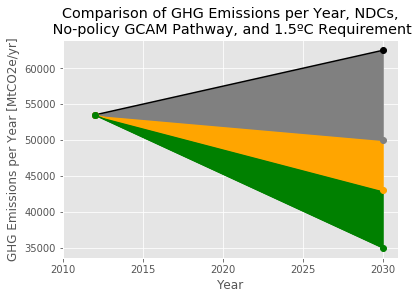

In [16]:
plt.xlabel('Year')
plt.ylabel('GHG Emissions per Year [MtCO2e/yr]')
plt.title('Comparison of GHG Emissions per Year, NDCs,\n No-policy GCAM Pathway, and 1.5ºC Requirement')
 
x1 = [2012,2030]
y1 = [ghgDf_WB[ ghgDf_WB['Country Name'] == 'World' ]['2012'], ghgForecast_GCAM_BAU['2030'].sum()]
y2 = [ghgDf_WB[ ghgDf_WB['Country Name'] == 'World' ]['2012'], 50000]
y3 = [ghgDf_WB[ ghgDf_WB['Country Name'] == 'World' ]['2012'], NDCs_clean.values.sum()]
y4 = [ghgDf_WB[ ghgDf_WB['Country Name'] == 'World' ]['2012'], 35000]

CoeffLineNoPolicy = np.polyfit(x1,y1,1)
CoeffLineLowTarget = np.polyfit(x1,y2,1)
CoeffLineNDCs = np.polyfit(x1,y3,1)
CoeffLineHighTarget = np.polyfit(x1,y4,1)

LineNoPolicy = np.poly1d(CoeffLineNoPolicy)
LineLowTarget = np.poly1d(CoeffLineLowTarget)
LineNDCs = np.poly1d(CoeffLineNDCs)
LineHighTarget = np.poly1d(CoeffLineHighTarget)

plt.plot(x1, LineNoPolicy(x1), "-o", color = "black")
plt.plot(x1, LineLowTarget(x1), "-o", color = "grey")
plt.plot(x1, LineNDCs(x1), "-o", color = "orange")
plt.plot(x1, LineHighTarget(x1), "-o", color = "green")

plt.fill_between(x1, LineNoPolicy(x1), LineLowTarget(x1), color = "grey")
plt.fill_between(x1, LineLowTarget(x1), LineNDCs(x1), color = "orange")
plt.fill_between(x1, LineNDCs(x1), LineHighTarget(x1), color = "green")
plt.xticks(range(2010, 2031, 5))
plt.show()


# BREAK IN ANALYSIS

The info below needs to be reorganized. - Jason

## Which countries need to more?

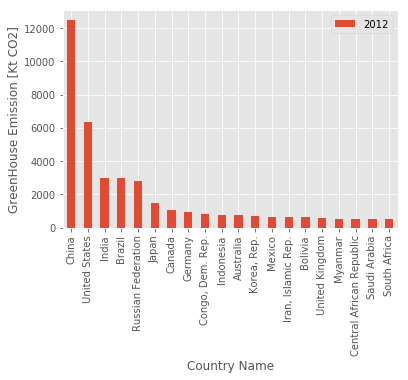

In [17]:
#Sorted bar chart of 2012 greenhouse gases

ghgCountryDf_WB.sort_values(by="2012", ascending=False)[["Country Name", "2012"]]

GreenhouseGasesTop20Emitters = ghgCountryDf_WB.sort_values(by = "2012", ascending = False).iloc[:20,:]

GreenhouseGasesTop20Emitters[["Country Name", "2012"]].plot(x = "Country Name", kind="bar")

plt.ylabel("GreenHouse Emission [Kt CO2]")
plt.show()

Time series for greenhouse gases of major (top 10 depending on V1) present polluters (from 1990 to most-recent)

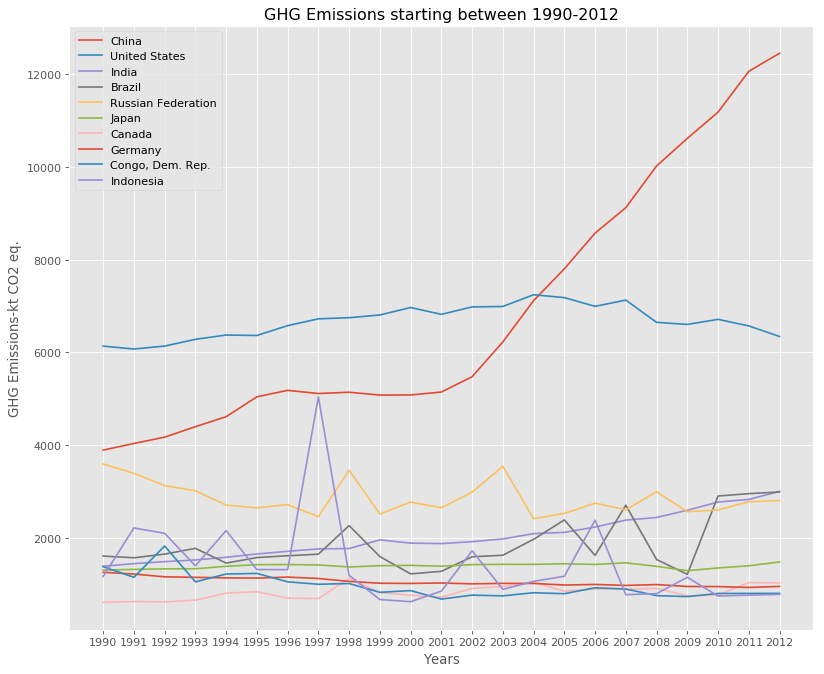

In [18]:
# Time series for ghg emissions of the top 10 most polluting countries.

GreenhouseGasesTop10Emitters = ghgCountryDf_WB.sort_values(by = "2012", ascending = False).iloc[:10,:]

plt.figure(figsize=(12, 10), dpi=80) 

for i in range(0,10):
    
    row = GreenhouseGasesTop10Emitters.iloc[i,22:]
    plt.plot(row)

plt.MaxNLocator(10)
plt.xlabel("Years")
plt.ylabel("GHG Emissions-kt CO2 eq.")
plt.title("GHG Emissions starting between 1990-2012")
#plt.legend(loc=((1.05,0.3)))#how to show country names instead of the numbers 
plt.legend(GreenhouseGasesTop10Emitters["Country Name"] )

plt.show()

We observe that the top polluter of the world China has increasing emissions starting from 1990s till 2012. The second polluter US, on the other hand shows a stable curve over the years. Until 2004 it is the top polluter of the world. India........

## Top 10 greenhouse gas emitters

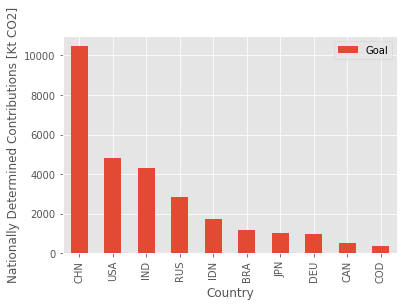

In [19]:
#Greenhouse reductions by countries according to their NDCs. Data is already converted to mtCO2e. Countries have different goals 
#in terms of which year they are based on and which year they aim also unconditional and conditional goals. Here the goals are  
#not based on year target but the minimum goal of each country is choosen?? 

#See if the ones who are most polluting also have the highest reduction aim

GreenhouseGasesTop10Emitters

NDCsTop10 = NDCs_clean.loc[ [i for i in GreenhouseGasesTop10Emitters["Country Code"].values] ]

NDCsTop10.head()

NDCsTop10= NDCsTop10.sort_values(by="Goal", ascending=False)

NDCsTop10.plot(kind="bar")

plt.ylabel("Nationally Determined Contributions [Kt CO2]")
plt.show()

IND-India
IDN-Indonesia
In the first graph we observed that China,US and India are the top 3 major polluters and their reduction targets allign with this ranking. In the greenhouse gases emission graph the list goes on as Brazil, Russia, Japan, Canada, Germany, Congo and Indonesia. Among these countries even though Indonesia is the least polluting among these, it has higher reduction goals than many of the rest of the countries. 

### 3. Analyzing carbon debt 
#### Is it fair to put the same burden of greenhouse reduction on developing countries considering the historical emissions produced by developed countries?

#### 3.1 Which contries have a high historical debt?

In [54]:
CO2From1850_CAIT = pd.read_excel("data/wri/CW_CAIT_GHG_Emissions_31102017_ISO.xlsx", sheet_name="CO2 Total Emissions",\
                                 index_col = "ISO")
CO2From1850_CAIT.index.rename("Country Code", inplace=True)
CO2From1850_CAIT.fillna(value = 0, inplace=True)
CO2From1850_CAIT.drop(columns = "Country", inplace = True)

In [55]:
CO2From1850_CAIT.head()

,Year,Total CO2 Emissions Excluding Land-Use Change and Forestry (MtCO2)
Country Code,,
AFG,1850,0.0
ALB,1850,0.0
DZA,1850,0.0
AND,1850,0.0
AGO,1850,0.0


In [56]:
CO2From1850_CAIT = CO2From1850_CAIT.pivot_table(values = "Total CO2 Emissions Excluding Land-Use Change and Forestry (MtCO2)",\
                                                index = "Country Code", columns = "Year")
CO2From1850_CAIT.head()

Year,1850,1851,1852,1853,1854,1855,1856,1857,1858,1859,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
Country Code,,,,,,,,,,,,,,,,,,,,,
AFG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.326368,1.652464,2.268016,4.202608,6.763744,8.452848,12.230432,10.746512,10.006384,9.801200
AGO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,18.348963,20.478275,23.629880,25.279221,27.350213,28.678816,29.574109,29.953059,31.823261,33.292413
ALB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.065488,4.050144,4.223344,4.168000,4.323264,4.578528,5.037680,4.575536,4.786832,5.215536
AND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.575248,0.545936,0.538608,0.538608,0.516624,0.516624,0.490976,0.487312,0.476320,0.461664
ARE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,117.679533,123.248565,133.764064,159.189384,158.273096,162.470085,169.914792,179.432443,183.152667,185.262891


In [114]:
CO2From1850_CAIT["Cummulative Emissions"] = CO2From1850_CAIT.sum(axis=1)
CountriesHighHistDebt = CO2From1850_CAIT.sort_values(by = "Cummulative Emissions", ascending=False).iloc[:15, :]
CountriesHighHistDebt = CountriesHighHistDebt[["Cummulative Emissions"]]
CountriesHighHistDebt.drop(index= ["WORLD", "EU28"], inplace=True)
CountriesHighHistDebt

Year,Cummulative Emissions
Country Code,
USA,749167.343877
CHN,337523.506960
RUS,210471.125303
DEU,172049.478288
GBR,142561.916773
JPN,105376.402923
IND,78664.745616
FRA,69193.407552
CAN,58202.984811


Text(0,0.5,'MTCO2')

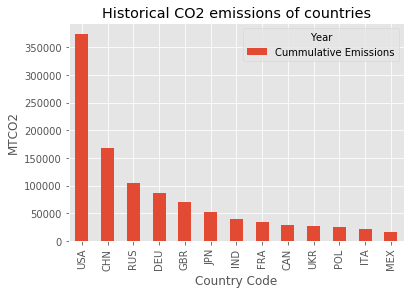

In [58]:
CountriesHighHistDebt.plot(kind="bar", title = "Historical CO2 emissions of countries")
plt.ylabel("MTCO2")

#### 3.3 How does the historical debt relate to their present GDP per capita (2018 values, `https://data.worldbank.org/indicator/NY.GDP.PCAP.CD`) and the % reduction in greenhouse gases promised for the year 2030?

In [59]:
#Random values of % reduction in historical debt to generate data for making the scatter plot
CountriesHighHistDebt["% reduction"] = np.random.uniform(size = len(CountriesHighHistDebt.index))

In [68]:
GDPperCapitaWB = pd.read_csv("data/World Bank/GDP_per_capita.csv", skiprows=4, index_col = "Country Code", header = 0)
GDPperCapitaWB.dropna(how="all", axis=0, inplace=True)
GDPperCapitaWB.dropna(how="all", axis=1, inplace=True)
GDPperCapitaWB.drop(columns = ["Indicator Name","Indicator Code"], inplace = True)
GDPperCapitaWB.iloc[:,1:] = GDPperCapitaWB.iloc[:,1:].interpolate(axis = 1)
GDPperCapitaWB.head()

,Country Name,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
Country Code,,,,,,,,,,,,,,,,,,,,,
ABW,Aruba,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,27546.899390,24631.434860,24271.940421,25324.720362,25324.720362,25324.720362,25324.720362,25324.720362,25324.720362,25324.720362
AFG,Afghanistan,59.777327,59.878153,58.492874,78.782758,82.208444,101.290471,137.899362,161.322,129.506654,...,373.361116,445.893298,553.300289,603.537023,669.009051,638.612543,629.345250,569.577923,561.778746,585.850064
AGO,Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3868.579014,3347.844900,3531.416878,4299.008136,4539.467689,4804.633826,4707.578098,3683.552607,3308.772828,4170.312280
ALB,Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4370.539647,4114.136545,4094.358832,4437.178068,4247.614308,4413.081697,4578.666728,3952.830781,4131.872341,4537.862492
AND,Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,47785.659086,43339.379875,39736.354063,41098.766942,38391.080867,40619.711298,42294.994727,36038.267604,37231.815671,39146.548836


In [71]:
GDPperCapita2017 = GDPperCapitaWB[["2017"]]
GDPperCapita2017.head()

,2017
Country Code,
ABW,25324.720362
AFG,585.850064
AGO,4170.312280
ALB,4537.862492
AND,39146.548836


In [73]:
CountriesHighHistDebt

Year,Cummulative Emissions,% reduction
Country Code,,
USA,374583.671939,0.782851
CHN,168761.753480,0.092789
RUS,105235.562651,0.434393
DEU,86024.739144,0.722186
GBR,71280.958387,0.078159
JPN,52688.201461,0.652300
IND,39332.372808,0.794387
FRA,34596.703776,0.146671
CAN,29101.492405,0.030037


In [78]:
#Merge the two datasets here based on the Country Name
HistoricalDebtMergedDf = CountriesHighHistDebt.join(GDPperCapita2017)
HistoricalDebtMergedDf

,Cummulative Emissions,% reduction,2017
Country Code,,,
USA,374583.671939,0.782851,59531.661964
CHN,168761.753480,0.092789,8826.994096
RUS,105235.562651,0.434393,10743.096592
DEU,86024.739144,0.722186,44469.909061
GBR,71280.958387,0.078159,39720.443427
JPN,52688.201461,0.652300,38428.097317
IND,39332.372808,0.794387,1939.612984
FRA,34596.703776,0.146671,38476.658636
CAN,29101.492405,0.030037,45032.119908


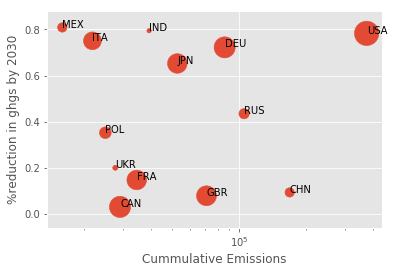

In [113]:
plt.scatter(x=HistoricalDebtMergedDf["Cummulative Emissions"],y=HistoricalDebtMergedDf["% reduction"],\
            s = HistoricalDebtMergedDf["2017"]/100)
plt.xscale("log")
plt.xlabel("Cummulative Emissions")
plt.ylabel("%reduction in ghgs by 2030")
for i in range(len(list(HistoricalDebtMergedDf.index))):
    plt.text(x=HistoricalDebtMergedDf.ix[i,"Cummulative Emissions"],y=HistoricalDebtMergedDf.ix[i,"% reduction"],\
         s = list(HistoricalDebtMergedDf.index)[i])
plt.grid(True)
plt.show()